In [1]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import os

#show me all the columns
pd.set_option('display.max_columns', None)

## Behind the scenes with geo files

Helpful Minneapolis codes:
- Minnesota is state fips 27
- Minneapolis is in Hennepin County, which is county fips 27053.

Where to download/find these GIS files for your state!
- **Schools:** [The NCES EDGE open data portal](https://data-nces.opendata.arcgis.com/) contains all sorts of helpful data, including school locations.
- **Neighborhoods:** check your city GIS site
- **Toxic Release Inventory:** Multiple years and states [available here](https://www.epa.gov/toxics-release-inventory-tri-program/tri-basic-data-files-calendar-years-1987-present)
- **Census Tigerline URLs:** [pick your vintage here](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html), then click FTP Archive and navigate to the shapefile you need.

In [2]:
gis_base = '../GIS'

#importing shapefiles and geojson
schools = gpd.read_file(f'{gis_base}/nces-mn-schools.geojson')

#importing from zip
hoods = gpd.read_file(f'{gis_base}/Minneapolis_Neighborhoods_4501150611105070206.zip')

#importing from url
tracts = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2024/TRACT/tl_2024_27_tract.zip')

#importing points from csv
tri = pd.read_csv(f'{gis_base}/epa-tri-2023-mn.csv')
tri = gpd.GeoDataFrame(tri, geometry=gpd.points_from_xy(tri['13. LONGITUDE'], tri['12. LATITUDE']))

In [ ]:
#exploring geodata is just like exploring any other dataframe
print('School count:',len(schools))
print(schools.dtypes)
display(schools.head())


#look the geometry!
print(schools.geometry)

#we can get the projection real quick too
print('Coordinate reference system:',schools.crs)

In [ ]:
#now you try looking at the other geodataframes crs

Cam is gonna talk about projects here for a minute. They're important friends.

In [ ]:
#quick viz
schools.plot()

## Slaying with APIs
A lot of ArcGIS maps have helpful API portals that will walk you thru querying and downloading the geojson.

Here's a video that shows you how to find that query page when you're looking at an ArcGIS map online:

Some of the data you try and pull down will clearly be accessible via API. Here's a video that shows you how to find the API page: 

In [3]:
#let's grab some data from the Minneapolis Open Data portal: 
# https://opendata.minneapolismn.gov/datasets/cityoflakes::public-311-2025/about
potholes = gpd.read_file("https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Public_311_2024/FeatureServer/0/query?where=TYPENAME%20%3D%20'Pothole'&outFields=*&outSR=4326&f=json")

In [ ]:
print(len(potholes))
display(potholes.head())
potholes.plot()

In [4]:
#sometimes an API requires an access key
#here's an example oh how to get Census ACS 5-yr data via the API
#and more info on the various APIs https://www.census.gov/data/developers/data-sets/acs-5year.html
#NOTE: different tables (detailed, subject, etc) have different geography levels available
def get_census_data(year,var_str,rename_cols):
    data_url = f'https://api.census.gov/data/{str(year)}/acs/acs5/subject?get={var_str}&for=tract:*&in=state:27%20county:053&key={MYKEY}'
    census_df = pd.read_json(data_url)
    new_header = census_df.iloc[0] #grab the first row for the header
    census_df = census_df[1:] #take the data less the header row
    census_df.columns = new_header #set the header row as the df header
    census_df.rename(columns=rename_cols, inplace=True) #heres where we actually rename

    #I recommend saving your API data to a file so you're not constantly hitting the API
    #census_df.to_csv(f'../data/analyzed/{str(year)}ACS5yr-hennipen-mn-tract-data.csv',index=False)
    
    return census_df

MYKEY = os.environ['census_api_key']

rename_cols = {
    'S0101_C01_001E':'pop',
    'S1901_C01_001E':'households',
    'S1901_C01_012E':'median_income',
    }

var_list = ['GEO_ID','NAME']+list(rename_cols.keys())
var_str = ','.join(var_list)
   
data_2023 = get_census_data(2023,var_str,rename_cols)

#convert our data columns to numeric
data_2023['pop'] = pd.to_numeric(data_2023['pop'],errors='coerce')
data_2023['households'] = pd.to_numeric(data_2023['households'],errors='coerce')
data_2023['median_income'] = pd.to_numeric(data_2023['median_income'],errors='coerce')

In [ ]:
print(data_2023.dtypes)

## Spatial joins and filtering

In [5]:
#filter one dataset by another
potholes_in_hoods = gpd.sjoin(potholes, hoods, predicate='within')

#remember, gdfs need to be in the same projection for spatial joins
potholes_4326 = potholes.to_crs(epsg=4326)
hoods_4326 = hoods.to_crs(epsg=4326)

potholes_in_hoods = gpd.sjoin(potholes_4326, hoods_4326, predicate='within')

/var/folders/2g/mqj0d6v95vbfcqgf7kpgrsrc0000gr/T/ipykernel_24115/2988623579.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3857

  potholes_in_hoods = gpd.sjoin(potholes, hoods, predicate='within')


In [ ]:
print(len(potholes))
print(len(potholes_in_hoods))
display(potholes_in_hoods.head())
potholes_in_hoods.plot()

## Count points in polygon
My fav way to do a point in polygon is to combine a spatial join and a groupby. First, the spatial join lets us connect a neighborhood name with each pothole, next, the groupby will let us count the potholes present in each neighborhood. 

In [6]:
#include parameter dropna=False to keep see how many potholes are outside of a neighborhood
potholes_per_hood = potholes_in_hoods.groupby('BDNAME',dropna=False).size().reset_index(name='potholes')

#if we wanna see the top 5 we need to remember to sort_values
potholes_per_hood.sort_values('potholes',ascending=False).head()

,BDNAME,potholes
25,Fulton,39
39,Linden Hills,29
78,Whittier,23
67,Standish,23
31,Howe,23


In [7]:
#if we feel like knowing more about the types of potholes in each hood, we can do a pivot_table instead
potholes_by_hood_type = pd.pivot_table(potholes_in_hoods, index='BDNAME',columns='CASESTATUS',
                                       values='CASEID',aggfunc='count',fill_value=0).reset_index()

#let's reset the columns names here
potholes_by_hood_type.rename(columns={0:'closed',1:'open'},inplace=True)

#and let's add a total column
potholes_by_hood_type['total'] = potholes_by_hood_type['closed'] + potholes_by_hood_type['open']

#and display sorted by total
potholes_by_hood_type.sort_values('total',ascending=False).head()

CASESTATUS,BDNAME,closed,open,total
25,Fulton,39,0,39
39,Linden Hills,29,0,29
78,Whittier,23,0,23
67,Standish,23,0,23
31,Howe,23,0,23


## Crosswalks
Generally, demographic data like population and median income isn't calculated for custom geographies like neighborhoods. But no matter! We can calculate that sort of information for ourselves using crosswalks.

In this example, we are going to cross Census tracts with Minneapolis neighborhoods.

In [8]:
#####################
# Add census data to the tracts
#####################

#make sure we can join on the GEOID cols
data_2023['GEOID'] = data_2023['GEO_ID'].str.replace('1400000US','')

#join
tracts_data = tracts.merge(data_2023, on='GEOID', how='left')
print(len(tracts_data.loc[~tracts_data['pop'].isnull()]))

#we need to make sure both gdfs are in the same projection, but unlike the spatial join
#we need to make sure that projection uses meters or feet because we'll be calculating area
#this projection is specific to the Twin Cities area: https://epsg.io/6505
tracts_data = tracts_data.to_crs(epsg=6505)
hoods = hoods.to_crs(epsg=6505)

#and we'll need to calculate the area of the tracts before and after we do the intersection so we can
#calculate the actual estimated count of people of different races in each tract segmemt.
tracts_data['pre_area'] = tracts_data['geometry'].area

#now let's do that intersection!
tracts_hoods = gpd.overlay(tracts_data, hoods, how='intersection')

#and calculate the area post intersection.  
tracts_hoods['post_area'] = tracts_hoods['geometry'].area

#from the pre and post area calculations we create a percentage
tracts_hoods['pct_area'] = tracts_hoods['post_area']/tracts_hoods['pre_area']

#and then we multiply our tract data counts by that percentage
#to get estimates per segments of the tract that falls within each hood
tracts_hoods['post_pop'] = tracts_hoods['pop'] * tracts_hoods['pct_area']
tracts_hoods['post_households'] = tracts_hoods['households'] * tracts_hoods['pct_area']
tracts_hoods['post_income'] = tracts_hoods['median_income'] * tracts_hoods['pct_area']

#groupby the neighborhood name so we can join back to our neighborhood shapes
hoods_data = tracts_hoods.groupby('BDNAME').agg({'post_pop':'sum',
                                                 'post_households':'sum',
                                                 'post_income':'mean'
                                                 }).reset_index()

329


In [ ]:
hoods_data.head()

## Buffers
Now, let's work with our schools and toxic release inventory data! I think it would be interesting to know which schools have a facility that releases toxic air or water chemicals near it. Shall we say 1 mile? If this were for an actual story, we would talk to an expert in the field to figure out the best distance to use.

Cam is gonna talk about finding experts to help inform your geographic analysis.

In [9]:
#first, we have to change the projection to get it into feet
schools = schools.to_crs(epsg=6505)

# Next, we draw a 1 mile buffer around each of our schools. The buffer distance depends on 
# the units of the CRS. Since our CRS is in feet, we need to convert 1 mile to feet.
schools['buffer'] = schools.buffer(5280)

In [ ]:
#if we inspect at this point, we can see we've added a new geometry column to our schools gdf
schools.head()

<Axes: >

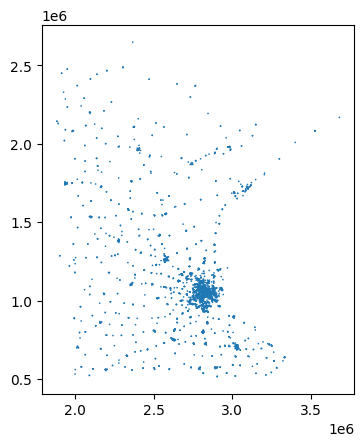

In [10]:
#let's make a school_buffers dataframe separate from our schools dataframe
school_buffers = schools.copy()

#and keep only the columns we need
keep_cols = ['NCESSCH','NAME','CITY','ZIP','NMCNTY','NMCBSA','buffer']
school_buffers = school_buffers[keep_cols]

#and set the geometry to the buffer
school_buffers.set_geometry('buffer',inplace=True)

#and we can plot it
school_buffers.plot()

In [12]:
#we're going to group the TRI by facility because with this dataset, a single facility will have 
#many rows, one for each chemical released
unique_tri = tri.groupby(['2. TRIFD','4. FACILITY NAME',
                          '5. STREET ADDRESS','6. CITY',
                          '7. COUNTY','geometry']).size().reset_index(name='chemicals_released')

#when we do the groupby, it stops being a geodataframe, so we need to make it one again
unique_tri = gpd.GeoDataFrame(unique_tri, geometry='geometry')

unique_tri.head()

,2. TRIFD,4. FACILITY NAME,5. STREET ADDRESS,6. CITY,7. COUNTY,geometry,chemicals_released
0,55003NDRSNFOOTO,ANDERSEN CORP,100 4TH AVE N,BAYPORT,WASHINGTON,POINT (-92.77953 45.02528),9
1,55003SKNGG1103K,XCEL ENERGY A. S. KING GENERATING PLANT,1103 KING RD,BAYPORT,WASHINGTON,POINT (-92.77902 45.02947),9
2,55009BRGQS301WA,HENKEL US OPERATIONS CORP,301 WASHINGTON ST W,CANNON FALLS,GOODHUE,POINT (-92.9043 44.51895),3
3,55009CNNNQ324WW,CANNON EQUIPMENT MIDWEST,324 W WASHINGTON ST,CANNON FALLS,GOODHUE,POINT (-92.90367 44.51896),1
4,55009GMNNC103ME,GEMINI - CANNON FALLS,103 MENSING WAY,CANNON FALLS,GOODHUE,POINT (-92.90595 44.52144),1


In [ ]:
# #now we can use what we've already learned about spatial joins and points in polygon to
# #to see which TRI facilities are within those 1 mile buffers

# #first get the tri geodataframe in the same projection as the buffers
# tri = tri.to_crs(epsg=4326)

# #ohhhhh dear. what in the world does this mean? Well it means that the CRS of a geodataframe we create from 
# #points_from_xy is not set. So we need to set it.
# #So first, comment out the offending line above and then run this:
# tri = tri.set_crs(epsg=4326)

In [16]:
# change the crs to 4326
school_buffers = school_buffers.to_crs(epsg=4326)
#unique_tri = unique_tri.to_crs(epsg=4326)

# #ohhhhh dear. what in the world does this mean? Well it means that the CRS of a geodataframe we create from 
# #points_from_xy is not set. So we need to set it.
# #So first, comment out the offending line above and then run this:
unique_tri = unique_tri.set_crs(epsg=4326)

#and now the spatial join
tri_schools = gpd.sjoin(unique_tri, school_buffers, predicate='within')

#and we can see how many facilities are within a mile of a school
print(len(tri))
print(len(tri_schools))
display(tri_schools.head())

1482
1461


,2. TRIFD,4. FACILITY NAME,5. STREET ADDRESS,6. CITY,7. COUNTY,geometry,chemicals_released,index_right,NCESSCH,NAME,CITY,ZIP,NMCNTY,NMCBSA
0,55003NDRSNFOOTO,ANDERSEN CORP,100 4TH AVE N,BAYPORT,WASHINGTON,POINT (-92.77953 45.02528),9,424,270027203327,MN CORRECTIONAL FACILITY-STILLWATER,BAYPORT,55003,Washington County,"Minneapolis-St. Paul-Bloomington, MN-WI"
0,55003NDRSNFOOTO,ANDERSEN CORP,100 4TH AVE N,BAYPORT,WASHINGTON,POINT (-92.77953 45.02528),9,2534,273819001655,ANDERSEN ELEMENTARY,BAYPORT,55003,Washington County,"Minneapolis-St. Paul-Bloomington, MN-WI"
1,55003SKNGG1103K,XCEL ENERGY A. S. KING GENERATING PLANT,1103 KING RD,BAYPORT,WASHINGTON,POINT (-92.77902 45.02947),9,424,270027203327,MN CORRECTIONAL FACILITY-STILLWATER,BAYPORT,55003,Washington County,"Minneapolis-St. Paul-Bloomington, MN-WI"
1,55003SKNGG1103K,XCEL ENERGY A. S. KING GENERATING PLANT,1103 KING RD,BAYPORT,WASHINGTON,POINT (-92.77902 45.02947),9,2534,273819001655,ANDERSEN ELEMENTARY,BAYPORT,55003,Washington County,"Minneapolis-St. Paul-Bloomington, MN-WI"
2,55009BRGQS301WA,HENKEL US OPERATIONS CORP,301 WASHINGTON ST W,CANNON FALLS,GOODHUE,POINT (-92.9043 44.51895),3,1043,270750000324,Cannon Falls Secondary,CANNON FALLS,55009,Goodhue County,"Red Wing, MN"


If you're asking yourself "why that CRS?" it's because when you do a spatial join with points, you need to everything to be in a geometric CRS rather than a projected CRS. I don't know man, ask Cam. She's way smarter than I am.

If you're further asking yourself "Why are there some schools in there more than once!?". It's because some schools have more than one facility within one mile of them. Le YIPE! 

But we know how to deal with that, right? We can groupby the school and count the facilities!

In [17]:
#if you're wondering why there are MORE tri_schools records than tri records, it's because
#some facilities are within a mile of more than one school. Le YIPE!
#but we know how to deal with that, right? We can groupby the school and count the facilities
tri_per_school = tri_schools.groupby(['NAME','CITY','NMCNTY']).size().reset_index(name='tri_facilities')

tri_per_school.sort_values('tri_facilities',ascending=False).head()

,NAME,CITY,NMCNTY,tri_facilities
452,MENLO PARK ACADEMY,MINNEAPOLIS,Hennepin County,9
88,Banaadir Elementary,MINNEAPOLIS,Hennepin County,9
494,Menlo Park Academy Extended,MINNEAPOLIS,Hennepin County,9
769,Spero Academy,MINNEAPOLIS,Hennepin County,7
564,Osseo Education Center,OSSEO,Hennepin County,7


## Calculating distance
So now we know which schools are within a mile of a TRI facility... but what if I wanted to know about the school with the closest TRI facility? Or maybe calculate all of the distances between schools and their closes TRI facility?

In [18]:
# you're gonna hate me... but we need to change these damn projections back to 6505 
# cause we need the feet!
schools = schools.to_crs(epsg=6505)
unique_tri = unique_tri.to_crs(epsg=6505)

#geopandas as a lovely function called sjoin_nearest that will do exactly what we want
closest_tri_school = gpd.sjoin_nearest(schools, unique_tri, max_distance=5280, distance_col='distance')

In [19]:
print(len(schools))
print(len(tri))
print(len(closest_tri_school))

2775
1482
882


In [20]:
closest_tri_school.head()

,NCESSCH,LEAID,NAME,OPSTFIPS,STREET,CITY,STATE,ZIP,STFIP,CNTY,NMCNTY,LOCALE,LAT,LON,CBSA,NMCBSA,CBSATYPE,CSA,NMCSA,CD,SLDL,SLDU,SCHOOLYEAR,geometry,buffer,index_right,2. TRIFD,4. FACILITY NAME,5. STREET ADDRESS,6. CITY,7. COUNTY,chemicals_released,distance
2,270000501769,2700005,UNITED SOUTH CENTRAL ELEMENTARY,27,600 11TH ST. SW,WELLS,MN,56097,27,27043,Faribault County,43,43.733990,-93.735299,N,N,0,N,N,2701,2723A,27023,2023-2024,POINT (2694632.023 595769),"POLYGON ((2699912.023 595769, 2699886.599 5952...",381,5609WWLLSR19FRA,CCM - WELLS,190 FRANKLIN ST NE,WELLS,FARIBAULT,2,5105.454815
3,270000501770,2700005,UNITED SOUTH CENTRAL HIGH SCHOOL,27,600 11TH ST. SW,WELLS,MN,56097,27,27043,Faribault County,43,43.733990,-93.735299,N,N,0,N,N,2701,2723A,27023,2023-2024,POINT (2694632.023 595769),"POLYGON ((2699912.023 595769, 2699886.599 5952...",381,5609WWLLSR19FRA,CCM - WELLS,190 FRANKLIN ST NE,WELLS,FARIBAULT,2,5105.454815
22,270001402222,2700014,Freshwater Education District ALC,27,2222 INDUSTRIAL DRIVE,WADENA,MN,56482,27,27159,Wadena County,41,46.420591,-95.131745,N,N,0,N,N,2707,2705B,27005,2023-2024,POINT (2339097.287 1577257.172),"POLYGON ((2344377.287 1577257.172, 2344351.863...",469,5648WHMCRS125HM,HOMECREST OUTDOOR LIVING - WADENA,1250 HOMECREST AVE SE,WADENA,WADENA,1,4598.190466
23,270001403297,2700014,White Pine Academy,27,2222 INDUSTRIAL DRIVE,WADENA,MN,56482,27,27159,Wadena County,41,46.420591,-95.131745,N,N,0,N,N,2707,2705B,27005,2023-2024,POINT (2339097.287 1577257.172),"POLYGON ((2344377.287 1577257.172, 2344351.863...",469,5648WHMCRS125HM,HOMECREST OUTDOOR LIVING - WADENA,1250 HOMECREST AVE SE,WADENA,WADENA,1,4598.190466
24,270001403670,2700014,EARLY CHILDHOOD SPECIAL EDUCATION,27,2222 INDUSTRIAL DRIVE,WADENA,MN,56482,27,27159,Wadena County,41,46.420591,-95.131745,N,N,0,N,N,2707,2705B,27005,2023-2024,POINT (2339097.287 1577257.172),"POLYGON ((2344377.287 1577257.172, 2344351.863...",469,5648WHMCRS125HM,HOMECREST OUTDOOR LIVING - WADENA,1250 HOMECREST AVE SE,WADENA,WADENA,1,4598.190466


## Exporting for viz